<a href="https://colab.research.google.com/github/delhian/recomender_systems/blob/main/RS_jester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Please see decription here http://eigentaste.berkeley.edu/dataset/

In [1]:
pip install surprise

     |████████████████████████████████| 11.8 MB 5.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619417 sha256=ec06c8ec3f08a237ef61d00b4d3c66ccd06eb562e12a1850d625da2f96739879
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
!unzip -qq jokes.zip

In [4]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from bs4 import BeautifulSoup as bs
from os import listdir
from os.path import isfile, join
pd.set_option('max_colwidth', 400)
import numpy as np
from collections import defaultdict
from surprise.model_selection import GridSearchCV

## Jokes

In [5]:
%%time

filenames_path= './jokes/'

filenames = [f for f in listdir(filenames_path) if '.htm' in f]

jokes = []

for filename in filenames:
    joke_id = int(filename.split('.')[0].replace('init','')) - 1
    with open(join(filenames_path, filename), 'r',) as file:
        text = bs(file, 'lxml').body.text.replace('\n',' ').strip()
        jokes.append([joke_id, text])
        
jokes = pd.DataFrame(jokes, columns = ['joke_id', 'text'])
jokes = jokes.sort_values('joke_id').reset_index(drop=True)
print(jokes.shape)
jokes.head()

(100, 2)
CPU times: user 88.4 ms, sys: 7.97 ms, total: 96.4 ms
Wall time: 106 ms


In [6]:
jokes.to_pickle('jokes.pkl')

## Ratings

In [7]:
%%time

filenames_path= './jokes/'

filenames = [f for f in listdir(filenames_path) if '.xls' in f]

ratings = []
for filename in filenames:
    tmp = pd.read_excel(join(filenames_path, filename), \
                        usecols = range(1, 101), header=None)
    ratings.append(tmp)

ratings = pd.concat(ratings)
ratings = ratings.reset_index(drop=True)

ratings.columns = range(100)

ratings['user_id'] = ratings.index

print(ratings.shape)
ratings.head()

(73421, 101)
CPU times: user 26.2 s, sys: 522 ms, total: 26.7 s
Wall time: 26.8 s


In [8]:
# melt:
ratings = pd.melt(ratings,
                      id_vars=['user_id'],
                      value_vars=range(100),
                      var_name = 'joke_id',
                      value_name = 'rating')

In [9]:
# remove unrated: 
ratings = ratings[ratings.rating != 99.00]

print(ratings.shape)

ratings['joke_id'] = ratings['joke_id'].astype('int64')

ratings.to_pickle('ratings.pkl')

ratings.head()

(4136360, 3)


,user_id,joke_id,rating
0,0,0,-7.82
1,1,0,4.08
4,4,0,8.50
5,5,0,-6.17
7,7,0,6.84


###  MODELS

In [10]:
import collections, random
from surprise import Reader, Dataset
from surprise.model_selection import KFold
from sklearn.model_selection import KFold as SKFold
import pandas as pd
from surprise import SVD, NMF, SlopeOne
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from surprise import accuracy

In [11]:
ratings = pd.read_pickle('ratings.pkl')
jokes = pd.read_pickle('jokes.pkl')
jokes_dict = {x[0]: x[1] for x in jokes.values}

In [12]:
reader = Reader(rating_scale = (-10, 10))
data = Dataset.load_from_df(ratings[['user_id', 'joke_id', 'rating']], reader)

###  Коллаборативная фильтрация: SVD, NMF, SlopeOne

### Используем cross-валидацию для оценки максимальной RMSE, которой можем достичь той или иной моделью:

In [13]:
%%time

kf = KFold(n_splits=5)
    
for model in [SVD(), NMF(), SlopeOne(), ]:
    print(f'model: {model.__class__}')
    rmse = []
    for ind, [trainset, testset] in enumerate(kf.split(data)):
        print(f'split:{ind}', end = ' ' )
        model.fit(trainset)
        predictions = model.test(testset)
    # Root Mean Squared Error :
        rmse.append(accuracy.rmse(predictions))
    print(f'mean RMSE at the all splits: {np.round(np.mean(rmse), 4)}\n')

model: <class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
split:0 RMSE: 4.4926
split:1 RMSE: 4.4815
split:2 RMSE: 4.4890
split:3 RMSE: 4.4761
split:4 RMSE: 4.4906
mean RMSE at the all splits: 4.486

model: <class 'surprise.prediction_algorithms.matrix_factorization.NMF'>
split:0 RMSE: 7.9622
split:1 RMSE: 5.3710
split:2 RMSE: 5.3507
split:3 RMSE: 6.8625
split:4 RMSE: 8.0313
mean RMSE at the all splits: 6.7155

model: <class 'surprise.prediction_algorithms.slope_one.SlopeOne'>
split:0 RMSE: 4.3853
split:1 RMSE: 4.3789
split:2 RMSE: 4.3841
split:3 RMSE: 4.3816
split:4 RMSE: 4.3787
mean RMSE at the all splits: 4.3817

CPU times: user 51min 30s, sys: 17.7 s, total: 51min 48s
Wall time: 51min 48s


### Т.о. лучшим себя показывает SVD
### Подберем гиперапараметры SVD и посмотрим, какое минимальное RMSE удастся достичь

In [14]:
# Будем подбирать гиперпараметры на 20% подвыборки по user_id :

n_user_ids = len(ratings.user_id.unique())
n_user_ids_subset = random.choices(ratings.user_id.unique(), k=n_user_ids//5)

reader = Reader(rating_scale = (-10, 10))
data = Dataset.load_from_df(ratings[['user_id', 'joke_id', 'rating']]\
                            [ratings.user_id.isin(n_user_ids_subset)], reader)

In [15]:
%%time
# Select your best algo with grid search.
print('Grid Search...')

param_grid = {'n_epochs': [20, 25, 30, 45], 'n_factors':  [100, 120, 130], 'lr_all': [0.003, 0.005, 0.01]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose = 1)
grid_search.fit(data)

Grid Search...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1h 42min 14s, sys: 34.1 s, total: 1h 42min 48s
Wall time: 1h 42min 45s


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 102.7min finished


In [16]:
grid_search.best_score, grid_search.best_params

({'rmse': 4.146901143417441},
 {'rmse': {'lr_all': 0.01, 'n_epochs': 45, 'n_factors': 130}})

###   В качестве модели выбираем SVD с найденными best_params, обучаемся на всех доступных данных:

In [18]:
%%time
trainingSet = data.build_full_trainset()
model = grid_search.best_estimator['rmse']
model.fit(trainingSet)

CPU times: user 2min 2s, sys: 309 ms, total: 2min 2s
Wall time: 2min 2s


###  Предсказываем rating (est) для всех пар user, joke (uid, iid), которые не присутствуют в тренировочном датасете:

In [19]:
%%time

trainingSet = data.build_full_trainset()
testingSet = trainingSet.build_anti_testset()
predicted = pd.DataFrame(model.test(testingSet))[['uid', 'iid', 'est']]

CPU times: user 11.7 s, sys: 387 ms, total: 12.1 s
Wall time: 11.7 s


###  Выведем примеры 2 шуток, которые понравились пользователю cо случайным u_id

In [52]:
u_id = random.choice(predicted[predicted.est > 8].uid.unique())
u_id

def print_jokes (iid_ratings, trainingSet, top_n):
    '''
    sort iid_ratings descendingly and print top_n - jokes
    
    Args:
    iid_ratings -> rating (est) for each items(iid) (pd.DataFrame, columns: 'iid', 'est')
    trainingSet -> trainingset built via: data.build_full_trainset() (surprise.trainset.Trainset)
    top_n -> nof tops (int)

    '''

    print(f'top-{top_n}:\n')
    iid_ratings = iid_ratings.sort_values('est', ascending = False)[:top_n]
    for _, row in iid_ratings.iterrows():
        print(f'est: {round(row.est, 2)}:')
        joke_id = trainingSet.to_raw_iid(row.iid)
        jokes_text = jokes_dict[joke_id]
        print(f'{jokes_text}', end = '\n')

iid_ratings = pd.DataFrame(trainingSet.ur[u_id], columns = ['iid', 'est'])
print_jokes(iid_ratings, trainingSet, 3)

top-3:

est: 6.5:
Q: Ever wonder why the IRS calls it Form 1040?  A: Because for every $50 that you earn, you get 10 and they get 40.
est: 5.68:
One Sunday morning William burst into the living room and said, "Dad! Mom! I have some great news for you! I am getting married to the most beautiful girl in town. She lives a block away and her name is Susan." After dinner, William's dad took him aside. "Son, I have to talk with you. Your mother and I have been married 30 years.. She's a wonderful wife but she has never offered much excitement in the bedroom, so I used to fool around with women a lot. Susan is actually your half-sister, and I'm afraid you can't marry her." William was heart-broken. After eight months he eventually started dating girls again. A year later he came home and very proudly announced, "Dianne said yes! We're getting married in June." Again his father insisted on another private conversation and broke the sad news. "Dianne is your half-sister too, William. I'm awfull

In [53]:
# Получаем предсказания для данного u_id:
iid_ratings_predicted = predicted[predicted.uid == u_id][['iid', 'est']]
print_jokes(iid_ratings_predicted, trainingSet, 3)

top-3:

est: 8.1:
On the first day of college, the Dean addressed the students, pointing out some of the rules:  "The female dormitory will be out-of-bounds for all male students and the male dormitory to the female students. Anybody caught breaking this rule will be finded $20 the first time." He continued, "Anybody  caught breaking this rule the second time will be fined $60. Being caught a third time will cost you a fine of $180. Are there any questions ?"  At this point, a male student in the crowd inquired: "How much for a season pass ?"
est: 7.69:
There was an engineer who had an exceptional gift for fixing all  things mechanical.  After serving his company loyally for over 30  years, he happily retired.  Several years later the company contacted  him regarding a seemingly impossible problem they were having with  one of their multi-million dollar machines. They had tried everything and  everyone else to get the machine fixed, but to no avail.  In  desperation, they called on the

### Для того, чтобы оценить качество ранжирования рекомендаций шуток посчитаем precision_recall_at_k

![image.png](attachment:image.png)

In [54]:
%%time

k = 10
threshold = 5

def precision_recall_at_k(predictions, k = k, threshold = threshold):
    '''
    Return precision and recall at k metrics for each user
    
    Args:
    predictions -> rating (est) for each items(iid) (pd.DataFrame, columns: 'iid', 'est')
    k -> nof tops (int)
    threshold -> rating threshold (float)
    
    Returns:
    dict, dict
    '''
    precisions = dict()
    recalls = dict()
    for uid in predictions['uid'].unique():
        uid_df = predictions[predictions.uid == uid]
        uid_df_top_k = uid_df.sort_values('est', ascending=False).iloc[:k]
        # Number of relevant items:
        n_rel = len(uid_df[uid_df.r_ui > threshold])
        # Number of recommended items in top k:
        n_rec_k = len(uid_df_top_k[uid_df_top_k.est > threshold])
        # Number of relevant and recommended items in top k:
        n_rel_and_rec_k = len(uid_df_top_k[(uid_df_top_k.est > threshold)&(uid_df_top_k.r_ui > threshold)])
        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

kf = KFold(n_splits = 5)

mp_on_ks = []
mr_on_ks = []

for ind, [trainset, testset] in enumerate(kf.split(data)):
    print(f'split {ind}:', end = ' ')
    model.fit(trainset)
    predictions = model.test(testset)
    predictions = pd.DataFrame(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=0)
    # Precision and recall averaged over all users:
    mp_on_k = sum(prec for prec in precisions.values()) / len(precisions)
    mr_on_k = sum(rec for rec in recalls.values()) / len(recalls) 
    print(f'mean_precision_on_{k}: {mp_on_k}', end =' ')
    print(f'mean_recall_on_{k}: {mr_on_k}')
    mp_on_ks.append(mp_on_k)
    mr_on_ks.append(mr_on_k)

print(f'mean_recall_on_{k}_avarage: {np.mean(mp_on_ks)}, mean_recall_on_{k}_avarage: {np.mean(mr_on_ks)}')

split 0: mean_precision_on_10: 0.6646490458891794 mean_recall_on_10: 0.6249621934466083
split 1: mean_precision_on_10: 0.662302659963719 mean_recall_on_10: 0.6217573994481208
split 2: mean_precision_on_10: 0.6668361591026292 mean_recall_on_10: 0.6250173811464758
split 3: mean_precision_on_10: 0.6675292151098566 mean_recall_on_10: 0.6250278475173471
split 4: mean_precision_on_10: 0.6659795655944296 mean_recall_on_10: 0.6253121014875337
mean_recall_on_10_avarage: 0.6654593291319627, mean_recall_on_10_avarage: 0.6244153846092171
CPU times: user 13min 49s, sys: 6.37 s, total: 13min 55s
Wall time: 13min 56s


# Проблемы "Холодного старта":


### 1. Что делать в случае, если появляется новый user, который ничего не оценивал или оценил еще слишком мало?

# Popular-based model

### Получаем для каждой joke_id общее количество оценок и средний рейтинг: 

In [66]:
ratings_grouped = ratings.groupby('joke_id')['rating'].agg({'mean', 'size'})\
.rename(columns = {'mean': 'rating_average','size': 'rating_count' }).reset_index()

ratings_grouped.head()

,joke_id,rating_average,rating_count
0,0,0.90,32024
1,1,0.16,35277
2,2,0.19,32402
3,3,-1.41,30512
4,4,0.24,73405


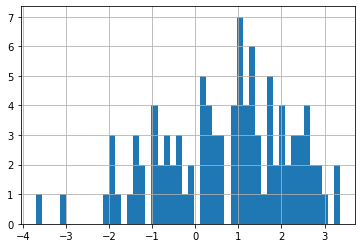

In [67]:
ratings_grouped['rating_average'].hist(bins=50)

In [68]:
C = ratings_grouped['rating_average'].mean()
print(f'average rating for the whole dataset: {C}')

average rating for the whole dataset: 0.7020177018236599


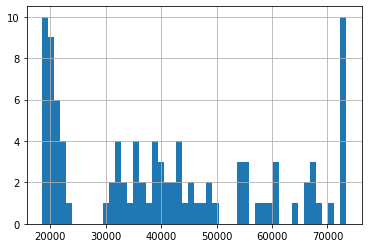

In [69]:
ratings_grouped['rating_count'].hist(bins=50)

In [70]:
m = ratings_grouped['rating_count'].min()
print(f'minimum votes required to be classified as popular: {m}')

minimum votes required to be classified as popular: 18505


### Подсчитаем взвешенные рейтинги шуток по формуле IMDB:

In [71]:
def weighted_rating(x, m=m, C=C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> rating counts for each item (pd.Series)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for each item (pd.Series)
    C -> average rating for the whole dataset (float)
    
    Returns:
    pd.Series
    '''
    v = x['rating_count']
    R = x['rating_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

ratings_grouped['weighted_rating'] = ratings_grouped.apply(weighted_rating, axis=1)

ratings_grouped.sort_values('weighted_rating', ascending = False, inplace = True)

ratings_grouped['text'] = ratings_grouped['joke_id'].map(jokes_dict)

ratings_grouped.head(10)

,joke_id,rating_average,rating_count,weighted_rating,text
49,49,3.36,70449,2.81,"A guy goes into confession and says to the priest, ""Father, I'm 80 years old, widower, with 11 grandchildren. Last night I met two beautiful flight attendants. They took me home and I made love to both of them. Twice."" The priest said: ""Well, my son, when was the last time you were in confession?"" ""Never Father, I'm Jewish."" ""So then, why are you telling me?"" ""I'm telling everybody."""
31,31,2.97,66300,2.48,"A man arrives at the gates of heaven. St. Peter asks, ""Religion?"" The man says, ""Methodist."" St. Peter looks down his list, and says, ""Go to room 24, but be very quiet as you pass room 8."" Another man arrives at the gates of heaven. ""Religion?"" ""Baptist."" ""Go to room 18, but be very quiet as you pass room 8."" A third man arrives at the gates. ""Religion?"" ""Jewish."" ""Go to room 11, but be ..."
35,35,2.92,68137,2.44,"A guy walks into a bar, orders a beer and says to the bartender, ""Hey, I got this great Polish Joke..."" The barkeep glares at him and says in a warning tone of voice: ""Before you go telling that joke you better know that I'm Polish, both bouncers are Polish and so are most of my customers"" ""Okay"" says the customer,""I'll tell it very slowly."""
26,26,2.91,67718,2.43,"Clinton returns from a vacation in Arkansas and walks down the steps of Air Force One with two pigs under his arms. At the bottom of the steps, he says to the honor guardsman, ""These are genuine Arkansas Razor-Back Hogs. I got this one for Chelsea and this one for Hillary."" The guardsman replies, ""Nice trade, Sir."""
34,34,2.78,66460,2.32,"An explorer in the deepest Amazon suddenly finds himself surrounded by a bloodthirsty group of natives. Upon surveying the situation, he says quietly to himself, ""Oh God, I'm screwed."" The sky darkens and a voice booms out, ""No, you are NOT screwed. Pick up that stone at your feet and bash in the head of the chief standing in front of you."" So with the stone he bashes the life out of the c..."
61,61,2.68,63574,2.23,"A group of managers were given the assignment to measure the height of a flagpole. So they go out to the flagpole with ladders and tape measures, and they're falling off the ladders, dropping the tape measures - the whole thing is just a mess. An engineer comes along and sees what they're trying to do, walks over, pulls the flagpole out of the ground, lays it flat, measures it from end to end..."
28,28,2.62,67065,2.20,"An old Scotsmen is sitting with a younger Scottish gentleman and says the boy. ""Ah, lad look out that window. You see that stone wall there, I built it with me own bare hands, placed every stone meself. But do they call me MacGregor the wall builder? No! He Takes a few sips of his beer then says, ""Aye, and look out on that lake and eye that beautiful pier. I built it meself, laid every bo..."
52,52,2.55,67068,2.15,"One Sunday morning William burst into the living room and said, ""Dad! Mom! I have some great news for you! I am getting married to the most beautiful girl in town. She lives a block away and her name is Susan."" After dinner, William's dad took him aside. ""Son, I have to talk with you. Your mother and I have been married 30 years.. She's a wonderful wife but she has never offered much excitemen..."
48,48,2.52,60608,2.09,"Three engineering students were gathered together discussing the possible designers of the human body. One said, ""It was a mechanical engineer. Just look at all the joints."" Another said, ""No, it was an electrical engineer. The nervous systems many thousands of electrical connections."" The last said, ""Actually it was a civil engineer. Who else would run a toxic waste pipeline through a ..."
88,88,3.35,20443,2.09,"A radio conversation of a US naval ship with Canadian authorities ... Americans: Please divert your course 15 degrees to the North to avoid a collision. Canadians: Recommend you divert YOUR course 15 degrees to the South to a

### Новым user предлагаем шутки с наибольшим weighted_rating

### 2. Что делать в случае, если появляется новая шутка, по которой нет оценок или оценок слишком мало?

# Content-based модель: новую шутку можно предложить тем пользователям, которые хорошо оценили шутку, близкую к новой по косинусной мере

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english', min_df = 3, max_df = 10)

tfidf_matrix = tfidf.fit_transform(jokes['text'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix, )

In [73]:
def get_recommendations(joke_id, cosine_sim, k):
    '''
    Return indices of jokes, which are closest to the current
    
    Args:
    joke_id -> indice of joke (int)
    cosine_sim -> cosine sim matrix (np.array)
    k -> nof tops (int)
    
    Returns:
    list
    '''
    sim_scores = list(enumerate(cosine_sim[joke_id]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k+1]
    print(sim_scores)
    jokes_indices = [i[0] for i in sim_scores]
    return jokes_indices

### Предположим, что шутка joke_id == 86 новая:

In [75]:
joke_id = 86

jokes.iloc[[joke_id]]

,joke_id,text
86,86,"A man, recently completing a routine physical examination receives a phone call from his doctor. The doctor says, ""I have some good news and some bad news."" The man says, ""OK, give me the good news first."" The doctor says, ""The good news is, you have 24 hours to live."" The man replies, ""Shit! That's the good news? Then what's the bad news?"" The doctor says, ""The bad news is, I forgot to..."


In [76]:
k=1
print(f'top-{k}:')

print(['joke_id='+str(x)+': '+jokes_dict[x] for x in get_recommendations(joke_id, cosine_sim, k=k)])

top-1:
[(0, 0.7322801154226467)]
['joke_id=0: A man visits the doctor. The doctor says "I have bad news for you.You have cancer and Alzheimer\'s disease".  The man replies "Well,thank God I don\'t have cancer!"']


Шутку мы можем рекомендовать тем user_id, которые давали высокую оценку близкой шутке с joke_id=30

In [77]:
ratings[(ratings.joke_id==30)&(ratings.rating>9)].sort_values('rating')[::-1]

,user_id,joke_id,rating
2276036,73406,30,9.76
2269563,66933,30,9.42
2234525,31895,30,9.37
2238224,35594,30,9.37
2238017,35387,30,9.37
...,...,...,...
2234499,31869,30,9.03
2233927,31297,30,9.03
2233744,31114,30,9.03
2211443,8813,30,9.03
